In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/cancer-mut-class/"))
data_dir="../input/cancer-mut-class/"
# Any results you write to the current directory are saved as output.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk import FreqDist
import string
from nltk.corpus import stopwords
import nltk
from nltk import word_tokenize, FreqDist

In [ ]:

# In[1]
df_train_txt = pd.read_csv(data_dir+'training_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_train_var = pd.read_csv(data_dir+'training_variants')
df_train = pd.merge(df_train_txt,df_train_var, how='left', on='ID')
df_train["Text"]=df_train["Text"]+" "+df_train["Gene"]+" "+df_train["Variation"]
df_train.head()

# In[1]
df_test_txt = pd.read_csv(data_dir+'test_text', sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
df_test_var = pd.read_csv(data_dir+'test_variants',header=None,names=["ID","Gene","Variation","Class"])
df_test = pd.merge(df_test_txt,df_test_var, how='left', on='ID')
df_test["Text"]=df_test["Text"]+" "+df_test["Gene"]+" "+df_test["Variation"]
df_test.head()

In [ ]:
# In[1]
stop = stopwords.words('english')+["mutat","cell","cancer","fig","mutant"]
snowball = nltk.SnowballStemmer('english')
WNlemma = nltk.WordNetLemmatizer()
def preprocess(toks):
    toks = [ t.lower() for t in toks if t not in string.punctuation ]
    toks = [t for t in toks if t not in stop ]
    toks = [ snowball.stem(t) for t in toks ]
    toks = [ WNlemma.lemmatize(t) for t in toks ]
    toks = [t for t in toks if t not in stop ]
    #toks_clean = [ t for t in toks if len(t) >= 3 ]
    return toks


In [ ]:

# In[1]
df_train['Text']=df_train['Text'].apply(lambda x: str(x))
df_train['Tokens'] = df_train['Text'].apply(lambda x: word_tokenize(x))
df_train['Tokens_clean'] = df_train['Tokens'].apply(lambda x: preprocess(x))
df_train['Tokens_clean_text'] = df_train['Tokens_clean'].apply(lambda x: ' '.join(x))
df_train['Length']=df_train['Tokens_clean'].apply(lambda x: len(x))

In [ ]:
train_y=np.array(["class "+str(t) for t in df_train['Class']])
test_y=np.array(["class "+str(t) for t in df_test['Class']])
classnames=['class 1', 'class 2', 'class 3', 'class 4', 'class 5', \
            'class 6', 'class 7', 'class 8', 'class 9']

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def word_cloud_class(category):
    class_words=df_train.Tokens_clean[df_train.Class==category]
    class_words_list = [ c for l in class_words for c in l ]
    fd_class_words = FreqDist(class_words_list)

    wc_grain = WordCloud(background_color="white").generate_from_frequencies(fd_class_words)
    plt.imshow(wc_grain, interpolation='bilinear')
    plt.axis("off")
    plt.show()
for i in range(1,10):
    word_cloud_class(i) 

In [ ]:
df_train.hist(column='Length',by='Class',bins=50)
plt.figure()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [ ]:
df_train.groupby('Class').describe()

In [ ]:
count_vect = CountVectorizer( )
X_train_counts = count_vect.fit_transform(df_train['Tokens_clean_text'])
tfidf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)
X_train_counts.shape

In [ ]:
import matplotlib
X=X_train_counts.todense()
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", \
                "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
plt.scatter(data2D[:,0], data2D[:,1], c=df_train["Class"], \
            cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [ ]:
df_test['Text']=df_test['Text'].apply(lambda x: str(x))
df_test['Tokens'] = df_test['Text'].apply(lambda x: word_tokenize(x))
df_test['Tokens_clean'] = df_test['Tokens'].apply(lambda x: preprocess(x))
df_test['Tokens_clean_text'] = df_test['Tokens_clean'].apply(lambda x: ' '.join(x))

In [ ]:
X_new_counts = count_vect.transform(df_test['Tokens_clean_text'])
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [ ]:
#Building Modeling by using Naïve Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train_y)
predicted = clf.predict(X_new_tfidf)
#predicted=df_test['Text'].apply(lambda x: make_prediction(x,clf))

In [ ]:
#SGD classifier
from sklearn.linear_model import SGDClassifier
text_clf_svm=SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42)
text_clf_svm.fit(X_train_tfidf, train_y)
predicted = text_clf_svm.predict(X_new_tfidf)

In [ ]:
#SVM Classifier
from sklearn import svm
text_clf_svm=svm.SVC(C=1.0,kernel='linear')
text_clf_svm.fit(X_train_tfidf, train_y)
predicted = text_clf_svm.predict(X_new_tfidf)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(classnames)

def run_lgb(train_X, train_y, test_X):
    
    X_train, X_val, y_train, y_val = \
    train_test_split(train_X, train_y, test_size=0.2, random_state=12)
    y_train=le.transform(y_train)
    y_val=le.transform(y_val)
    params = {
        "objective" : "multiclass",
        "num_class": 9,
        "num_iterations": 1000,
        "learning_rate": 0.01,
        "metric" : "multiclass",
        "num_leaves" : 130,
        'num_trees':500,
        "max_bin":255,
        "verbosity" : -1
    }
    evals_result={}
    lgtrain = lgb.Dataset(X_train, y_train)
    lgval = lgb.Dataset(X_val, y_val)
    model = lgb.train(params, lgtrain, valid_sets=[lgval], early_stopping_rounds=200, \
                      verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result
lgbresults=run_lgb(X_train_tfidf, train_y, X_new_tfidf)

In [ ]:
pred_class=np.argmax(lgbresults[0],axis=1)
predicted=le.inverse_transform(pred_class)

In [23]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

             precision    recall  f1-score   support

    class 1       0.70      0.65      0.67        94
    class 2       0.57      0.43      0.49        46
    class 3       0.40      0.57      0.47         7
    class 4       0.63      0.66      0.64        64
    class 5       0.62      0.72      0.67        25
    class 6       0.64      0.64      0.64        22
    class 7       0.75      0.83      0.79       101
    class 8       0.00      0.00      0.00         2
    class 9       1.00      0.83      0.91         6

avg / total       0.67      0.68      0.67       367

Confusion matrix, without normalization


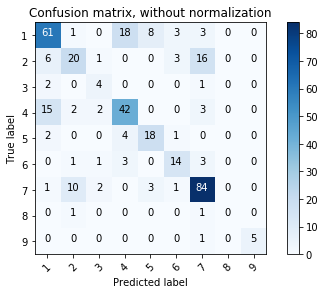

<Figure size 432x288 with 0 Axes>

0.6757493188010899


In [24]:
from sklearn import metrics 

print(metrics.classification_report(test_y, predicted))
cnf_matrix= metrics.confusion_matrix(test_y, predicted)
plot_confusion_matrix(cnf_matrix, classes=[i for i in range(1,10)],
                      title='Confusion matrix, without normalization')
plt.figure()
plt.show()
print(np.mean(predicted == test_y) )

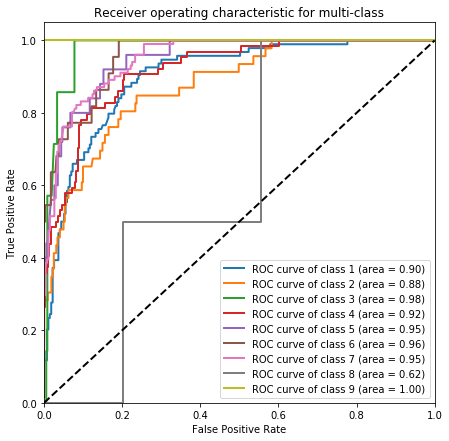

In [25]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

y_actual_binary = label_binarize(test_y, classes=classnames)
y_pred_binary = lgbresults[0]#label_binarize(predicted, classes=classnames)
n_classes=9
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))

colors = cycle(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", \
                "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

In [ ]:
df1=pd.DataFrame(lgbresults[0],columns=[1,2,3,4,5,6,7,8,9])
df1.to_csv("probab.csv")
df2=pd.DataFrame(predicted)
df2.to_csv("predict.csv")
df3=pd.DataFrame(lgbresults[2])
df3.to_csv("eval_results.csv")